# Paramètres <br/>
$D$ la demande du client <br/>
$PPA_t$ la production du PPA (de prix $p_{PPA} = 20 €/ MWh$) <br/>
$p_t$ le prix de l'éléricité sur le marché <br/>
$e_{bat}$ l'éfficité de la batterie <br/>
$c_{bat}$ la capacité de la batterie <br/>
$f_{bat}$ le flux maximal de la batterie <br/>
$e_{elec}$ l'éfficité de l'électrolyseur <br/>
$c_{elec}$ la capacit_é de l'électrolyseur <br/>
$c_{tank}$ la capacité du réservoir <br/>

# Variables <br/>
$\text{charge}_t$ la charge de la batterie à l'heure $t$ (en MWh)<br/>
$\text{prod}_t$ la production de l'électrolyseur à l'heure $t$ (en kg $H_2$)<br/>
$\text{stock}_t$ le stock d'hydrogène dans le reservoir à l'heure $t$ (en kg $H_2$)<br/>
$\text{elec}_t$ la consommation d'élécricité venant de la grille à l'heure $t$ (en MWh) <br/>
$\text{consPPA}_t$ la consommation d'élécricité venant du PPA à l'heure $t$ (en MWh) <br/>

# Contraintes <br/>

Satisfaction de la demande du client : <br/>
$\forall t \in [|1, T|], \text{prod}_t + \text{stock}_t = D_t + \text{stock}_{t+1}$ <br/>
Consomation d'élécricité : <br/>
$\forall t \in [|1, T|], \text{elec}_t + \text{consPPA}_t + e_{bat} \times \text{charge}_t = e_{elec} \times \text{prod}_t + \text{charge}_{t+1}$ <br/>
Contraintes de capacité : <br/>
$\forall t \in [|1, T|], \text{charge}_t \leq c_{bat}$ <br/>
$\forall t \in [|1, T|], \text{prod}_t \times e_{elec} \leq c_{elec} $ <br/>
$\forall t \in [|1, T|], \text{stock}_t \leq c_{tank} $ <br/>
$\forall t \in [|1, T|], \text{consPPA}_t \leq PPA_t $ <br/>
Contraintes de flux : <br/>
$\forall t \in [|1, T|], |\text{charge}_t - \text{charge}_{t+1}| \leq f_{bat} $ <br/>

# Objectif <br/>

Minimiser le coût de l'élécricité : <br/>
$\min \sum_{t=1}^{T} p_t \times \text{elec}_t + p_{PPA} \times \text{consPPA}_t$

In [ ]:
# Parameters
# Capacitté determiné par : qté totale d'energie dipso = un peu plus que la quantité totae d'energie pour satisfaire la demande fixée (D = 1000 kg/h par exemple)
# Problème d'optim pour determiner les capacité à installer ?
# Cout d'installation => meilleure résilience / constance de la rpoduction => obtenue avec les couts d'installation  de stockage
# capa * sum(profle) =  0.95 * Demand * Time (0.95 arbitraire, à ajuster)
wind_capa = None # Tbd as said above
solar_capa = None # Tbd as said above
wind_profile = None # Tbd from the database, depending on the year
solar_profile = None # Tbd from the database, depending on the year

# First steps, using a whole year of data (we have 3 such years)
# determination des capacités de stockage  => min de cappex + curtailment costs + imports
# Coût de l'import / curtaiilment => très hauts & constants, pour être utilisés en dernier recours 

In [29]:
from pulp import *
import matplotlib.pyplot as plt
import solver

In [30]:
# Default values
D = 1000 # Kg of H2
PPA = [50] * 18 + [40, 30, 20, 10, 0, 50] # Mwh
PPPA = 20 # € / MWh
PT = [20.79, 17.41, 16.24, 11.9, 9.77, 15.88, 24.88, 29.7, 35.01, 33.95, 29.9, 29.03] # € / MWh
PT += [27.07, 26.43, 27.53, 29.05, 31.42, 39.92, 41.3, 41.51, 39.75, 30.13, 30.36, 32.4]

EBAT = 0.9
CBAT = 400 # MWh
FBAT = 100 # MW

EELEC = 0.050 # Mwh / Kg
CELEC = 1000 # MW

CTANK = 500 # Kg

T = len(PPA)

In [31]:
output = solver.solve(D, PPA, PPPA, PT, EBAT, CBAT, FBAT, EELEC, CELEC, CTANK, T, 0, 0)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/nicolas/.local/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b1122486c6154b0bb67e2712db758888-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/b1122486c6154b0bb67e2712db758888-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 250 COLUMNS
At line 736 RHS
At line 982 BOUNDS
At line 983 ENDATA
Problem MODEL has 245 rows, 170 columns and 437 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 20 (-225) rows, 42 (-128) columns and 61 (-376) elements
0  Obj 26158.9 Primal inf 0.10033047 (19)
19  Obj 26158.9
Optimal - objective value 26158.9
After Postsolve, objective 26158.9, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 26158.9 - 19 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00  

In [32]:
prod_out = output["prod"]
charge_out = output["charge"]
stock_out = output["stock"]
elec_out = output["elecGrid"]
consPPA_out = output["consPPA"]

Text(0.5, 1.0, 'H2 production and stock, constant demand of 1000 Kg')

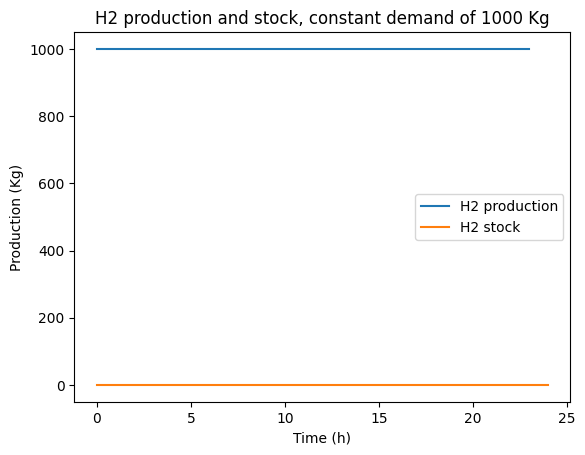

In [33]:
# Plot the production
fig, ax = plt.subplots()

ax.plot(range(T), prod_out, label = "H2 production")
ax.plot(range(T+1), stock_out, label = "H2 stock")
ax.legend()
ax.set_xlabel("Time (h)")
ax.set_ylabel("Production (Kg)")
ax.set_title(f"H2 production and stock, constant demand of {D} Kg")

Text(0.5, 1.0, 'Prices')

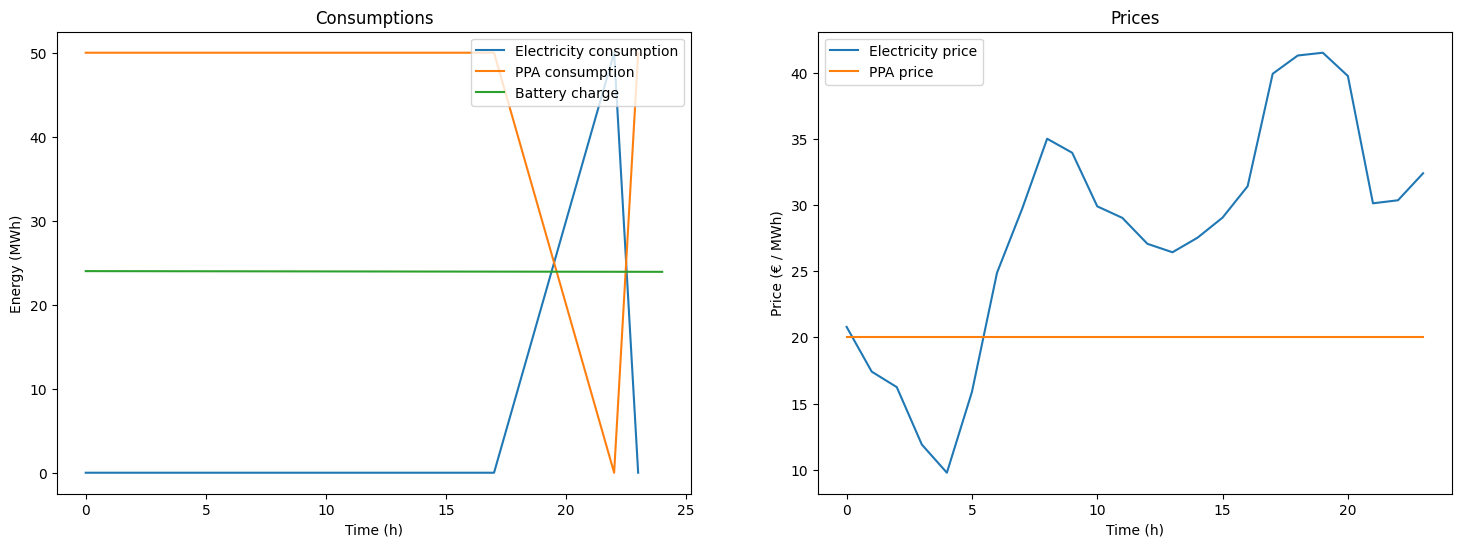

In [34]:
fig = plt.figure(figsize = (18, 6))
# Plot the consumptions
ax = fig.add_subplot(121)
ax.plot(range(T), elec_out, label="Electricity consumption")
ax.plot(range(T), consPPA_out, label="PPA consumption")
ax.plot(range(T+1), charge_out, label="Battery charge")
ax.legend()
ax.set_xlabel("Time (h)")
ax.set_ylabel("Energy (MWh)")
ax.set_title("Consumptions")
# Plot the prices
ax2 = fig.add_subplot(122)
ax2.plot(range(T), Pt, label="Electricity price")
ax2.plot(range(T), [PPPA] * T, label="PPA price")
ax2.legend()
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Price (€ / MWh)")
ax2.set_title("Prices")

